# GPT-2 Fine-Tuning Tutorial using raw text corpus

From Rey Farhan (https://reyfarhan.com/posts/easy-gpt2-finetuning-huggingface/)




This is a simplified script for fine-tuning GPT2 using Hugging Face's [Transformers library](https://huggingface.co/transformers/) and PyTorch on raw data. 

---------
Your task is to modify this assignment on raw text of your choice (I have put Pride and Prejudice as an example below) and include 10 sample generations from your chosen text that you find interesting. 


# Setup

In [1]:
!pip install transformers

     |████████████████████████████████| 2.2MB 8.5MB/s 
     |████████████████████████████████| 3.3MB 48.0MB/s 
     |████████████████████████████████| 870kB 53.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=f1b9f393ea0acf7299150b24bf64e6123d46e94ff09a04dc8262dfe08980cd03
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


In [2]:
import os
import time
import datetime
from google.colab import drive

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
% matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
import logging
import transformers
logging.getLogger("transformers").setLevel(logging.ERROR)  # No warning on sample size

In [4]:
!nvidia-smi

Sun Apr 11 01:52:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Create Training Set

The data used to finetune the language model is a set of around 1000 DJ biographies, with the aim of generating them in the same general format and style.

This data isn't public so if you want to use this script, you'll have to source your own training set.

In [5]:
# mount my Google Drive directory and access the training data located there
gdrive_dir = '/content/gdrive/'
drive.mount(gdrive_dir, force_remount=True)

Mounted at /content/gdrive/


In [6]:
data_dir = "/content/gdrive/MyDrive/Colab_Notebooks/data"
filename = 'prideAndPrejudice.txt'

In [7]:
# copy the data to the current Colab working directory
!cp $data_dir/$filename .

In [8]:
f=open(filename)
bios=f.readlines()
bios=[b.strip() for b in bios]
print(len(bios))

2063


We need to get an idea of how long our training documents are.

I'm not going to use the same tokenizer as the GPT2 one, which is a [byte pair encoding tokenizer](https://blog.floydhub.com/tokenization-nlp/). Instead, I'm using a simple one just to get a rough understanding.

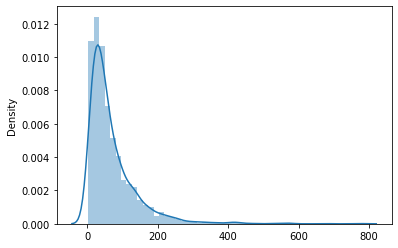

In [9]:
doc_lengths = []
for bio in bios:
    # get rough token count distribution
    tokens = nltk.word_tokenize(bio)
    doc_lengths.append(len(tokens))
doc_lengths = np.array(doc_lengths)
sns.distplot(doc_lengths)

In [10]:
# the max token length   
len(doc_lengths[doc_lengths > 768])/len(doc_lengths)

0.0004847309743092584

In [11]:
np.average(doc_lengths)

69.48715462918081

Even though these token counts won't match up to the BPE tokenizer's, I'm confident that most bios will be fit under the 768 embedding size limit for the small GPT2 model.

# GPT2 Tokenizer

Although the defaults take care of this,I thought I'd show that you can specify some of the special tokens. 

In [12]:
# Load the GPT tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium


Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


In [13]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


# PyTorch Datasets & Dataloaders


GPT2 is a large model. Increasing the batch size above 2 has lead to out of memory problems. This can be mitigated by accumulating the gradients but that is out of scope here.

In [14]:
batch_size = 2

I'm using the standard PyTorch approach of loading data in using a [dataset class](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

I'm passing in the tokenizer as an argument but normally I would  instantiate it within the class.

In [15]:
class GPT2Dataset(Dataset):

    def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):

        self.tokenizer = tokenizer
        self.input_ids = []
        self.attn_masks = []

        for txt in txt_list:

            encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

            self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
            self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attn_masks[idx] 

To understand how I've used the tokenizer, it's worth reading [the docs](https://huggingface.co/transformers/main_classes/tokenizer.html). I've wrapped each bio in the bos and eos tokens.

Every tensor passed to the model should be the same length.

If the bio is shorter than 768 tokens, it will be padded to a length of 768 using the padding token. In addition, an attention mask will be returned that needs to be passed to the model to tell it to ignore the padding tokens. 

If the bio is longer than 768 tokens, it will be truncated without the eos_token. This isn't a problem.

In [16]:
dataset = GPT2Dataset(bios, tokenizer, max_length=768)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

1,856 training samples
  207 validation samples


In [17]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# Finetune GPT2 Language Model

In [18]:
# I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [22]:
# some parameters I cooked up that work reasonably well

epochs = 4
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

In [23]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

In [24]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [25]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [26]:
def train(model):
    total_t0 = time.time()
    training_stats = []
    model = model.to(device)

    for epoch_i in range(0, epochs):
        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')

        t0 = time.time()
        total_train_loss = 0
        model.train()

        for step, batch in enumerate(train_dataloader):

            b_input_ids = batch[0].to(device)
            b_labels = batch[0].to(device)
            b_masks = batch[1].to(device)

            model.zero_grad()        

            outputs = model(b_input_ids,
                            labels=b_labels, 
                            attention_mask = b_masks,
                            token_type_ids=None
                            )

            loss = outputs[0]  

            batch_loss = loss.item()
            total_train_loss += batch_loss

            # Get sample every x batches.
            if step % sample_every == 0 and not step == 0:

                elapsed = format_time(time.time() - t0)
                print('Step {}/{}, Loss: {}, Elapsed: {}'.format(step, len(train_dataloader), batch_loss, elapsed))
                model.eval()
                sample_outputs = model.generate(
                                        bos_token_id=random.randint(1,30000),
                                        do_sample=True,   
                                        top_k=50, 
                                        max_length = 200,
                                        top_p=0.95, 
                                        num_return_sequences=1
                                    )
                for i, sample_output in enumerate(sample_outputs):
                    print("{}: {}\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
                
                model.train()
            loss.backward()
            optimizer.step()
            scheduler.step()

        # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(train_dataloader)       
        
        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)

        print("")
        print("Average training loss: {0:.2f}".format(avg_train_loss))
        print("Training epoch took: {:}".format(training_time))
            
        # ========================================
        #               Validation
        # ========================================

        print("")
        print("Running Validation...")

        t0 = time.time()

        model.eval()

        total_eval_loss = 0
        nb_eval_steps = 0

        # Evaluate data for one epoch
        for batch in validation_dataloader:
            
            b_input_ids = batch[0].to(device)
            b_labels = batch[0].to(device)
            b_masks = batch[1].to(device)
            
            with torch.no_grad():        

                outputs  = model(b_input_ids, 
    #                            token_type_ids=None, 
                                attention_mask = b_masks,
                                labels=b_labels)
            
                loss = outputs[0]  
                
            batch_loss = loss.item()
            total_eval_loss += batch_loss        

        avg_val_loss = total_eval_loss / len(validation_dataloader)
        
        validation_time = format_time(time.time() - t0)    

        print("Validation Loss: {0:.2f}".format(avg_val_loss))
        print("Validation took: {:}".format(validation_time))

        # Record all statistics from this epoch.
        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                'Training Time': training_time,
                'Validation Time': validation_time
            }
        )

    print("")
    print("Training complete!")
    print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
    return training_stats

In [27]:
training_stats = train(model)


======== Epoch 1 / 4 ========
Training...
Step 100/928, Loss: 0.3815542459487915, Elapsed: 0:00:29
0:  bipartisan"I believe in the power of perseverance, for she may find comfort in this way," said Mr. Dine, in conversation withMr. Witherings and Mrs. Sheppys of her aunt; which surprised her; which she had so much admiration for him as she could make them agree; which she had, of course, wished to give them encouragement on this point.

Step 200/928, Loss: 0.16303406655788422, Elapsed: 0:00:59
0:  increasing"We shall be able to do so, and shall know with a great deal of credit what you have done."

Step 300/928, Loss: 0.3195599615573883, Elapsed: 0:01:28
0: day: When she saw how many hours had been spent in such an effort to satisfy herself, she could not help taking notice of it; and as they were together in her room, she continued to admire Mr. Wickham as well as to admire him. At the sight of his charming face, she answered with a smile:

Step 400/928, Loss: 0.1358759105205536, Ela

Let's view the summary of the training process.

In [28]:
def view_stats(training_stats):
    # Display floats with two decimal places.
    pd.set_option('precision', 2)

    # Create a DataFrame from our training statistics.
    df_stats = pd.DataFrame(data=training_stats)

    # Use the 'epoch' as the row index.
    df_stats = df_stats.set_index('epoch')

    # A hack to force the column headers to wrap.
    #df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

    # Display the table.
    return df_stats

In [29]:
df_stats = view_stats(training_stats)
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,0.55,0.32,0:04:34,0:00:10
2,0.32,0.32,0:04:36,0:00:10
3,0.27,0.32,0:04:32,0:00:10
4,0.23,0.33,0:04:32,0:00:10


In [30]:
def show_status(df_stats):
    # Use plot styling from seaborn.
    sns.set(style='darkgrid')

    # Increase the plot size and font size.
    sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (12,6)

    # Plot the learning curve.
    plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
    plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

    # Label the plot.
    plt.title("Training & Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.xticks([1, 2, 3, 4])

    plt.show()

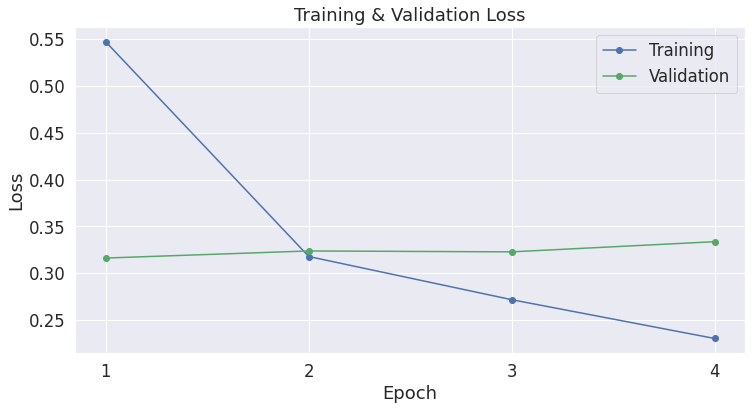

In [31]:
show_status(df_stats)

# Display Model Info

In [32]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))
print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50259, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

# Saving & Loading Fine-Tuned Model


In [33]:
def save_model(output_dir):
    # Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

    # Create output directory if needed
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    print("Saving model to %s" % output_dir)

    # Save a trained model, configuration and tokenizer using `save_pretrained()`.
    # They can then be reloaded using `from_pretrained()`
    model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
    model_to_save.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)

    # Good practice: save your training arguments together with the trained model
    # torch.save(args, os.path.join(output_dir, 'training_args.bin'))


In [34]:
# output_dir = './model_save/'
# save_model(output_dir)

In [35]:
# Copy the model files to a directory in your Google Drive.
# !cp -r ./model_save/ $data_dir

# # Load a trained model and vocabulary that you have fine-tuned
# model = GPT2LMHeadModel.from_pretrained(output_dir)
# tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
# model.to(device)

# Generate Text

In [36]:
def generate_text(model):
    model.eval()

    prompt = "<|startoftext|>"

    prompt = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
    prompt = prompt.to(device)

    sample_outputs = model.generate(
        prompt, 
        #bos_token_id=random.randint(1,30000),
        do_sample=True,   
        top_k=50, 
        max_length = 300,
        top_p=0.95, 
        num_return_sequences=3
    )

    for i, sample_output in enumerate(sample_outputs):
        print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

In [37]:
generate_text(model)

0: "If I had been able to see you," said her aunt, "there would have been very little for me."


1: "Yes, indeed, I do. They are each of us a family, and I will never look in the same room twice. Every room has its own share of beauty and its own special charm. I have always admired my brother Darcy for this. When I was in Kent, I knew his importance as a person. At that moment of his life he was the first man in the world, after my uncle and aunt had been; and I thought it incumbent to promote his advancement by encouraging him to play at heart; and I do believe I was encouraged by his character."


2: "I do not often see such good breeding."




# (10 pts) These aren't bad at all! Now train the model on your chosen text and report 10 example generations that you think are interesting!


> Use Donald Trump Speeches Data

In [38]:
filename = 'speeches.txt'

In [39]:
# copy the data to the current Colab working directory
!cp $data_dir/$filename .

In [40]:
text_list = []
with open(filename) as f:
    for line in f:
        text = line.strip()
        if len(text) > 0:
            text_list.append(text)

In [41]:
text_list[:5]

['\ufeffSPEECH 1',
 "...Thank you so much.  That's so nice.  Isn't he a great guy.  He doesn't get a fair press; he doesn't get it.  It's just not fair.  And I have to tell you I'm here, and very strongly here, because I have great respect for Steve King and have great respect likewise for Citizens United, David and everybody, and tremendous resect for the Tea Party.  Also, also the people of Iowa.  They have something in common.  Hard-working people.  They want to work, they want to make the country great.  I love the people of Iowa.  So that's the way it is.  Very simple.",
 "With that said, our country is really headed in the wrong direction with a president who is doing an absolutely terrible job.  The world is collapsing around us, and many of the problems we've caused.  Our president is either grossly incompetent, a word that more and more people are using, and I think I was the first to use it, or he has a completely different agenda than you want to know about, which could be p

In [42]:
batch_size = 4

In [43]:
dataset = GPT2Dataset(text_list, tokenizer, max_length=768)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

3,834 training samples
  426 validation samples


In [44]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [45]:
# I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [46]:
# some parameters I cooked up that work reasonably well

epochs = 4
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

In [47]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

In [48]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [49]:
training_stats = train(model)


======== Epoch 1 / 4 ========
Training...
Step 100/959, Loss: 0.15014149248600006, Elapsed: 0:00:56
0:  bipartisan or even a million dollars by the end of the day."And you know what?" he said. "You know what?"

Step 200/959, Loss: 0.17252852022647858, Elapsed: 0:01:53
0:  increasingAs I watched, I thought: "Here is what will happen. I’ll take over and make America great again."

Step 300/959, Loss: 0.23925773799419403, Elapsed: 0:02:49
0: dayI want to use a vote to save the United States from being destroyed by terrorist attack."I said, "Where can you get rid from the bomb – and I said, "Where can I have the whole country and they won’t make it? So go back and find another way to get rid." Right? So I said, "Where can they get rid from the bomb?"

Step 400/959, Loss: 0.1552736759185791, Elapsed: 0:03:46
0:  HangIn fact, they have a whole lot of room to grow. And they’re growing.

Step 500/959, Loss: 0.17542806267738342, Elapsed: 0:04:42
0:  foodsAnd, frankly, it’s nice. I have to tell

In [50]:
df_stats = view_stats(training_stats)
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,0.28,0.18,0:09:02,0:00:20
2,0.17,0.17,0:09:02,0:00:20
3,0.14,0.18,0:09:03,0:00:20
4,0.12,0.18,0:09:02,0:00:20


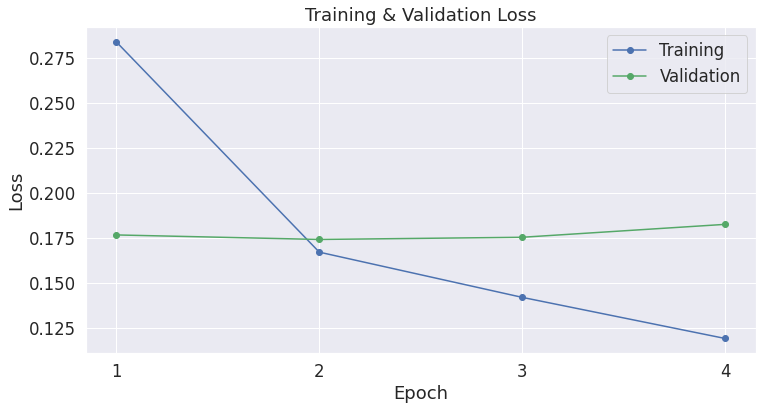

In [51]:
show_status(df_stats)

In [52]:
generate_text(model)

0: We’re going to protect everybody. We’re going to protect the Second Amendment. You know, we are going to protect everybody. And remember, we’re the law enforcement state.


1: Now, he’s getting a call from ABC, which is much bigger than I thought I was going to be able to handle. So we are going to try to do something about that. I believe we’re going to have a very successful period of time. But it’s going to be very expensive. You know, when people check into a hotel and they don’t want to wait, when they want to wait because they’re being treated badly, when they have the choice, they go through a whole process that takes them $200 million or $300 million.


2: And what happened is — they were in Pakistan, they were in Yemen, they were on the move, and they were looking for a job, and they couldn’t get it.




In [53]:
output_dir = './model_save/'
save_model(output_dir)

Saving model to ./model_save/


In [54]:
#Copy the model files to a directory in your Google Drive.
!cp -r ./model_save/ $data_dir